# Fruit Ripeness Classification
## CMPE 257 Project

We would like to help grocery retailers prevent fruit wastage by identifying fruits that are starting to become rotten. Upon detection of rottenness, the grocery retailers could donate the rotten fruits to a food bank. Thus, the fruits starting to become rotten will not get wasted and people can still eat it, as opposed to letting it rot in the grocery store and ending up in waste.

Our main implementation goal was to implement computer vision models that can predict whether a fruit is ripe or rotten based on an image with one fruit in it. We selected 6 fruits: apples, oranges, bananas, bell peppers, and mangos. Each team member used a pre-trained ResNet50 model and applied transfer learning. We trained a unique model for each fruit.


## Project Introduction
### 1.1 Abstract 
Grocery retailers tend to not capitalize on redistribution of expiring fruit to food banks to maximize profit. This leads to excessive food waste. Proposed in the following sections is a project proposal detailing the creation of a model that, given an image, can classify the fruit contained within and assess how close the fruit is to expiration. The models that will be used are ResNet, Vision Transformers, and YOLOv8. They will be analyzed by performance metrics such as accuracy, precision, recall, and ROC curve. 
### 1.2 Project Background 
Fruit is a key diet component for attaining a healthy lifestyle and life longevity. As a result, there is a high demand for the global fruit market. In the US alone, the fruits and vegetables market size was valued at 96.26 billion in 2023 [1]. 
This demand is high despite the fact that fruit as a product is quite volatile: it has a shelf life that is short. Grocery stores attempt to get the product into consumer hands before its expiry, yet a large percentage of product still becomes waste. In 2022, it was estimated that grocery stores had 5 million tons of surplus food, 30% of which went straight to landfill [2]. 
Since a percentage of fruits shelved are destined for expiration, a solution is to give the food to those in need at no cost. However, grocery stores will only pull products from the shelves for donations at the last possible moment. As a result, grocery stores tend to miss the window of opportunity, and the food inevitably goes to waste. 
It is the intention of this proposal to attempt to solve this problem: to alert grocery retailers when fruits, which have a short shelf life, are approaching their expiration and are in the best interest of the retailer to alert institutions to redistribute the food for the benefit of others. In this proposal, we present an outline for a project that, given images of fruit, will identify their species, and correctly identify when they are close to expiration. 

### 1.3 Datasets 
We will be utilizing several datasets from Kaggle. The first is of ripe and rotten apples, oranges, and bananas, where each category (i.e. ripe apples, rotten oranges, etc.) from the training data has 1400+ images. The source also provides a separate set of testing data with the same categories as the above [3].
Our second dataset is “Fruit and Vegetable Disease (Healthy vs Rotten)” which has 29 thousand files of 14 types of fruits and vegetables. These include apples, bell peppers, and guava. Each has their own fresh and rotten image set. All images have a mixture of flat white backgrounds and busy backgrounds [4]. 
When training the model for object detection and classification we will use “Fruits by YOLO”. This dataset has nearly 3000 images with labels for the location and type of fruit in the image. Some images have multiple fruits and types of fruits within them, and ideally this will increase the robustness of our model [5].


### 1.2 Goals and Objectives
The preliminary goal of this project is to research 3 existing models, and possibly improve their design, to detect and classify one fruit type. In order to properly report and quantify the success of our models: we will be using standard success metrics for classification learning models. These metrics include: 
Accuracy - Total successful model guesses (eg. ripe vs rotten) over all guesses
Precision - Total correct positive guesses over all model positive guesses (eg. all correct positive ripe guesses over all positive guesses) 
Recall - Total positive correct guesses over all positive samples (eg. all correct positive ripe guesses over all positive ripe samples)
Receiver Operating Characteristic (ROC) - graph that shows the true positive rate over the false positive rate given differing thresholds for classification
Every intermediary model will be reporting / visualizing these metrics in order to report progress. As a preliminary goal for our final model, we would like to achieve the following:

Accuracy, Precision, Recall - 85% accuracy in reporting the ripeness quality of a given fruit and its fruit type classification 
ROC Curve - No specific metric goal, but would like to target a very high TRP with very low threshold for both fruit classification and ripeness classification 

We will use a versioning system (see 2.2.4.2) which will document each significant model change we make, and corresponding results. 



---
### Tomato Model by Megan Gross

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import tensorflow as tf
import pathlib
testPath= '/content/drive/MyDrive/Colab Notebooks/tomatoData/Test'
trainPath= '/content/drive/MyDrive/Colab Notebooks/tomatoData/Train'

For Keras image_dataset_from_directory, the batch size for loading/yielding images defaults to 32 if none is given.

In [ ]:
batchSize=32
imgHeight=256
imgWidth=256

In [ ]:
train=tf.keras.utils.image_dataset_from_directory(
    trainPath,  validation_split=0.2, subset="training", seed=257, label_mode="categorical",
    image_size=(imgHeight, imgWidth), batch_size=batchSize)

Found 3684 files belonging to 2 classes.
Using 2948 files for training.


In [ ]:
val=tf.keras.utils.image_dataset_from_directory(
    trainPath,  validation_split=0.2, subset="validation",label_mode="categorical", seed=257,
    image_size=(imgHeight, imgWidth), batch_size=batchSize)

Found 3684 files belonging to 2 classes.
Using 736 files for validation.


In [ ]:
test=tf.keras.utils.image_dataset_from_directory(
    testPath, shuffle=True,validation_split=None, subset=None, label_mode="categorical", seed=257,
    image_size=(imgHeight, imgWidth), batch_size=batchSize)

Found 608 files belonging to 2 classes.


In [ ]:
classNames=train.class_names
valClassNames=val.class_names
print(classNames)

['freshtomato', 'rottentomato']


#### Visualize

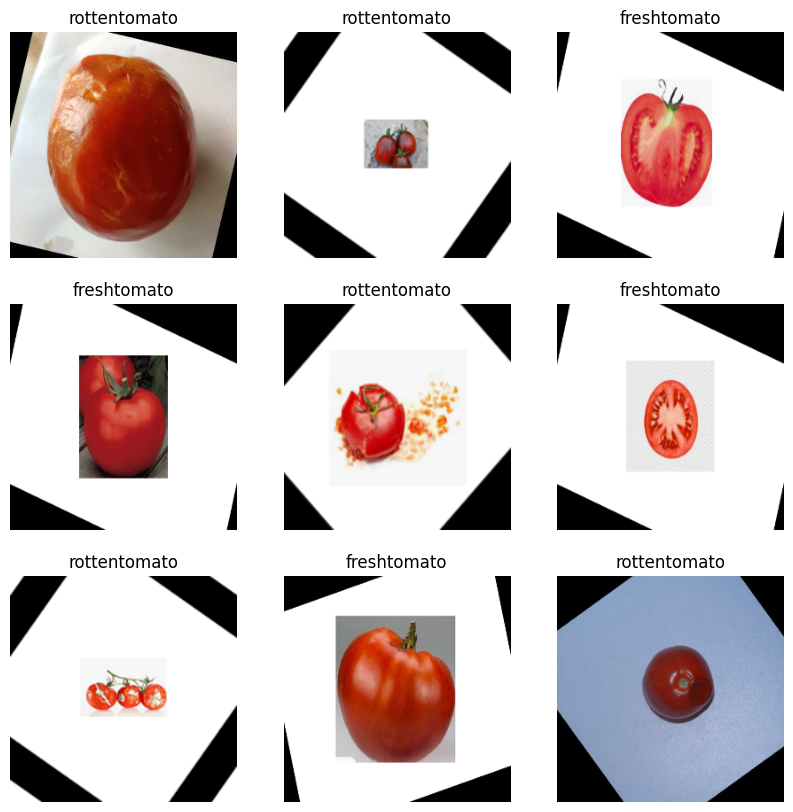

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train.take(1):
    for i in range(9):
        az=plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_label_index = tf.argmax(labels[i]).numpy()
        plt.title(classNames[predicted_label_index])
        plt.axis("off")

In [ ]:
resNet= tf.keras.applications.resnet50.ResNet50(include_top=False,input_shape=(256,256,3),pooling='avg',weights='imagenet')
resNet.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=(imgHeight, imgWidth, 3)))
model.add(resNet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [ ]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers import Adam


model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,637,826 (93.99 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
cnn=model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 999s 11s/step - accuracy: 0.8091 - loss: 0.7258 - precision: 0.8091 - recall: 0.8091 - val_accuracy: 0.9864 - val_loss: 0.0470 - val_precision: 0.9864 - val_recall: 0.9864
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1024s 10s/step - accuracy: 0.9884 - loss: 0.0401 - precision: 0.9884 - recall: 0.9884 - val_accuracy: 0.9918 - val_loss: 0.0321 - val_precision: 0.9918 - val_recall: 0.9918
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 983s 10s/step - accuracy: 0.9902 - loss: 0.0281 - precision: 0.9902 - recall: 0.9902 - val_accuracy: 0.9905 - val_loss: 0.0279 - val_precision: 0.9905 - val_recall: 0.9905
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 982s 10s/step - accuracy: 0.9905 - loss: 0.0284 - precision: 0.9905 - recall: 0.9905 - val_accuracy: 0.9864 - val_loss: 0.0365 - val_precision: 0.9864 - val_recall: 0.9864
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 970s 10s/step - accuracy: 0.9917 - loss: 0.0179 - precision: 0.9917 - recall: 0.9917 - val_accuracy: 0.9932 - val_loss: 0

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 162s 8s/step - accuracy: 1.0000 - loss: 2.5237e-04 - precision: 1.0000 - recall: 1.0000


In [ ]:
model.save("tomato_20epochs.keras", overwrite=True)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(val)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9963 - loss: 0.0113


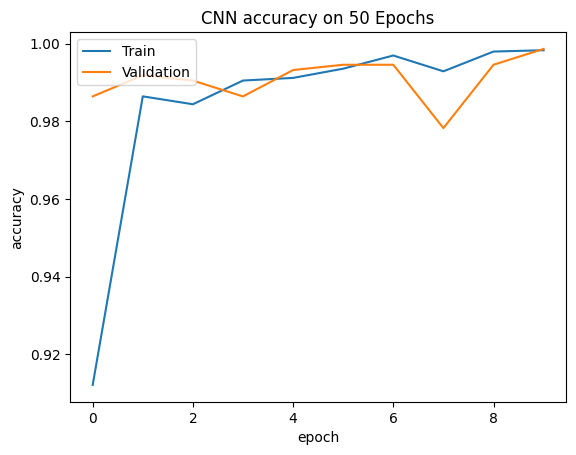

In [ ]:
import matplotlib.pyplot as plt

plt.plot(modelLoaded.history['accuracy'])
plt.plot(modelLoaded.history['val_accuracy'])
plt.title('CNN accuracy on 10 Epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

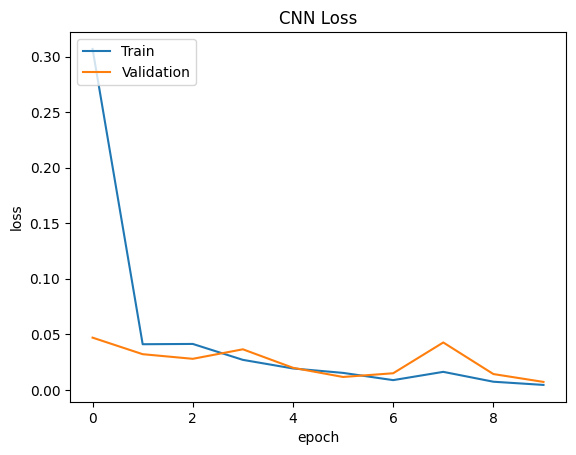

In [ ]:
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


---
### Apple Model by Lindsey Raven





In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
import sys
import logging
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# configure logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [ ]:
# configure to also print to console
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)

In [ ]:
# Create a file handler to log to a file
file_handler = logging.FileHandler('apple_model_logs.log')  # Specify the log file name
file_handler.setLevel(logging.DEBUG)  # You can change the level for file logging


In [ ]:
# Create a formatter to define the log message format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

In [ ]:
# add the handler to the logger
logger.addHandler(handler)
logger.addHandler(file_handler)

In [ ]:
# Dataset pathing
DATASET_DIRECTORY = "/Users/lindseyraven/Desktop/MSAI_SJSU_Work/CMPE257_ML/Fruit And Vegetable Diseases Dataset"
# TRAIN_DIRECTORY = os.path.join(DATASET_DIRECTORY, "train")
# VAL_DIRECTORY = os.path.join(DATASET_DIRECTORY, "validation")
# TEST_DIRECTORY = os.path.join(DATASET_DIRECTORY, "test")

# Hyperparameters
NUM_EPOCHS = 100
RESULTS_EPOCH = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 32

In [ ]:
# retrieves the provided dataset based on the image transform and dataset location
def load_dataset(path, transform):
    # retrieve the dataset based on path
    logger.info('load_dataset(): reading dataset...')
    dataset = datasets.ImageFolder(root=path, transform=transform)
    logger.info('load_dataset(): dataset classes are: '+str(dataset.classes))
    return dataset

In [ ]:
# splits the dataset into train / test split and uses stratify to ensure equal distribution of each class
def split_dataset(dataset):
    logger.info('split_dataset(): splitting the dataset into train test split...')
    # get the indices and labels for stratification
    indices = list(range(len(dataset)))

    # retrive the class labels from the dataset
    labels = [sample[1] for sample in dataset]

    # perform stratified split (80% train, 20% validation)
    train_indices, val_indices = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)

    # split datasets based on found indices for training and validation
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    num_train_samples = len(train_dataset)
    num_val_samples = len(val_dataset)
    logger.info(f'split_dataset(): number of train samples:{num_train_samples}, number of val samples:{num_val_samples}')
    return train_dataset, val_dataset

In [ ]:
# modify pre-trained resnet50 model to accept new classes and store on device
def resnet50_modified_model(num_classes, device):

    # load pre-trained ResNet-50 model
    model = models.resnet50(pretrained=True)

    # modify the output layer to reflect the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # move the model to the appropriate device
    model = model.to(device)

    return model

In [ ]:
def train_resnet50_model(model, device, train_loader, val_loader = None):
    logger.info('train_resnet50_model(): beginning model training...')

    # define loss function and optimizer to be used for training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # change the model mode to train (note: make sure that this is called appropriately if interspersing training and val)
    model.train()

    # training loop

    train_losses = []
    train_accuracy = []
    train_precision = []
    train_recall = []
    val_accuracy = []
    val_precision = []
    val_recall = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        correct_labels = []
        incorrect_labels = []
        all_labels = []
        all_preds = []
        total = 0
        correct = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            if (val_loader != None):
                # get retrieve validation data
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Append true labels and predictions to lists
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Store image info for future display
            for i in range((inputs.size(0))):
                if predicted[i] == labels[i]:  # Correct classification
                    correct_labels.append(labels[i].item())
                else:  # Incorrect classification
                    incorrect_labels.append(labels[i].item())

        # print accuracy results of training
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        logger.info(f'train_resnet50_model(): epoch [{epoch + 1}/{NUM_EPOCHS}], loss: {epoch_train_loss:.4f}')

        if((val_loader != None) and (epoch%RESULTS_EPOCH == 0)):
            # validate the resnet50 model every 10 epochs
            # Compute precision
            precision = precision_score(all_labels, all_preds, average='weighted')
            logger.info(f'train_resnet50_model(): Epoch: {epoch} validation Precision: {precision:.2f}%')

            # Compute recall
            recall = recall_score(all_labels, all_preds, average='weighted')
            logger.info(f'train_resnet50_model(): Epoch: {epoch} validation Recall: {recall:.2f}%')

            # Compute accuracy
            accuracy = 100 * correct / total
            logger.info(f'train_resnet50_model(): Epoch: {epoch} validation Accuracy: {accuracy:.2f}%')

            val_acc, val_pres, val_rec = validate_resnet50_model(model, device, val_loader, epoch)

            train_accuracy.append(accuracy)
            train_precision.append(precision)
            train_recall.append(recall)
            val_accuracy.append(val_acc)
            val_precision.append(val_pres)
            val_recall.append(val_rec)
            model.train()

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.savefig('loss_plot.png')

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy Score')
    plt.title('Accuracy Score Over Epochs')
    plt.legend()
    plt.savefig('Accuracy_plot.png')

    plt.figure(figsize=(10, 5))
    plt.plot(train_recall, label='Train Recall')
    plt.plot(val_recall, label='Val Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall Score')
    plt.title('Recall Score Over Epochs')
    plt.legend()
    plt.savefig('Recall_plot.png')

    plt.figure(figsize=(10, 5))
    plt.plot(train_precision, label='Train Precision')
    plt.plot(val_precision, label='Val Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision Score')
    plt.title('Precision Score Over Epochs')
    plt.legend()
    plt.savefig('Precision_plot.png')

    logger.info('train_resnet50_model(): training complete.')

In [ ]:
# Function to show an image with a title
def show_image(image, ax, title=None):
    image = np.transpose(image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

    # If the image is in the range [0, 1], scale it to [0, 255]
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8)

    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')

In [ ]:
def validate_resnet50_model(model, device, val_loader, epoch = None):
    logger.info('validate_resnet50_model(): beginning model validation...')

    if(epoch == None):
        # set epoch to 0 if not validating during training
        epoch = 0

    # change the model to validate
    model.eval()
    correct = 0
    total = 0

    # lists storing images for display
    correct_images = []
    correct_labels = []
    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []
    all_labels = []
    all_preds = []

    # set torch.no_grad to save computation time, no need to update gradients during val phase
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append true labels and predictions to lists
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Store image info for future display
            for i in range((inputs.size(0))):
                if predicted[i] == labels[i]:  # Correct classification
                    correct_images.append(inputs[i].cpu().numpy())
                    correct_labels.append(labels[i].item())
                else:  # Incorrect classification
                    incorrect_images.append(inputs[i].cpu().numpy())
                    incorrect_labels.append(labels[i].item())
                    incorrect_preds.append(predicted[i].item())

    # Plotting correctly classified images
    fig, axes = plt.subplots(1, min(5, len(correct_images)), figsize=(15, 5))
    for i, ax in enumerate(axes):
        show_image(correct_images[i], ax, title=f'True: {correct_labels[i]}')
    plt.suptitle('Correctly Classified Images')
    plt.savefig(f'correctly_classified_images_epoch{epoch}.png')


    # Plotting incorrectly classified images with predictions
    fig, axes = plt.subplots(1, min(5, len(incorrect_images)), figsize=(15, 5))
    for i, ax in enumerate(axes):
        show_image(incorrect_images[i], ax, title=f'True: {incorrect_labels[i]}\nPred: {incorrect_preds[i]}')
    plt.suptitle('Incorrectly Classified Images')
    plt.savefig(f'incorrectly_classified_images_epoch{epoch}.png')

    # Compute precision
    precision = precision_score(all_labels, all_preds, average='weighted')
    logger.info(f'validate_resnet50_model(): Epoch: {epoch} validation Precision: {precision:.2f}%')

    # Compute recall
    recall = recall_score(all_labels, all_preds, average='weighted')
    logger.info(f'validate_resnet50_model(): Epoch: {epoch} validation Recall: {recall:.2f}%')

    # Compute accuracy
    accuracy = 100 * correct / total
    logger.info(f'validate_resnet50_model(): Epoch: {epoch} validation Accuracy: {accuracy:.2f}%')
    logger.info(f'validate_resnet50_model(): Epoch: {epoch} validation complete.')
    return accuracy, precision, recall


In [ ]:
def save_model(model):
    # Save the trained model (note pth is the standard model type for pytorch)
    torch.save(model.state_dict(), 'resnet50_image_classification_apple.pth')
    logger.info('save_model(): model stored.')

In [ ]:
def check_available_device():
    if(torch.cuda.is_available()):
        device = torch.device("cuda")
        logger.info('check_available_device(): cuda device will be used.')
    elif(torch.backends.mps.is_available()):
        device = torch.device("mps")
        logger.info('check_available_device(): mps device will be used.')
    else:
        device = torch.device("cpu")
        logger.info('check_available_device(): cpu device will be used.')

    return device

In [ ]:
def main():
    logger.info('main(): began main')

    # configure model device usage
    device = check_available_device()

    # image transformations (resize, crop, normalization)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the input size expected by ResNet
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization as per ImageNet
    ])

    # load the dataset
    dataset = load_dataset(DATASET_DIRECTORY, transform)

    # split the dataset into train test split
    train_dataset, val_dataset = split_dataset(dataset)

    num_classes = len(dataset.classes)

    # define data loaders for the datasets
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # load and update pre-trained resnet50 model
    model = resnet50_modified_model(num_classes, device)

    # train the resnet50 model
    train_resnet50_model(model, device, train_loader, val_loader)

    # store the resnet50 model for later usage
    save_model(model)
    logger.info('main(): end main')

In [ ]:
if __name__ == '__main__':
    main()

---
### Banana Model by Peter Conant


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
import os

In [ ]:
model = keras.models.load_model("rotten_identiffier.keras")

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
TRAIN_PATH = "C:\\Users\\peter\\Documents\\SJSU\\CMPE_257_ML\\ML_SJSU_Fall_2024_Grp3\\Bananas"

train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="training",
    seed=257,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical')

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="validation",
    seed=257,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical')

#### Create Model(s)
Peter created several models to test different theories, layers, and activations functions.

#### Original Model
This is the original model created. The results from this model were used in the report and presentation.

In [ ]:
#Original Model Creation. Very confusing. Results form this model were used in the Presentation and Report
base_model= tf.keras.applications.resnet50.ResNet50(
                    include_top=False,
                    input_shape=(224,224,3),
                    pooling='avg',
                    weights='imagenet'
                    )

base_model.trainable = False                      #Freeze resnet model weights
inputs = Input(shape=(224, 224, 3))               #Create Input Layer
x = base_model(inputs, training=False)            # Add Input Layer
resnet_model = Sequential()                       # Initialize model builder
x = Flatten()(x)                                  # Add a flattening layer to be able to feed resnet results into less dementional layers
x = Dense(512, activation='relu')(x)              # Add a dense relu layer to process Resnet results
outputs = Dense(2, activation='softmax')(x)       # Softmax activation to ensure we get a result (either rotten or ripe)
model_original = Model(inputs, outputs)           # Add the output layer to rest of the model
model_original.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])
model_original.summary()

In [ ]:
#Fit Original Model
epochs=#0
history_model_original = model_original.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)
print(history_model_original.history)

In [ ]:
# 5 epochs of the original model
history_model_original.history = {'accuracy': [0.9705236554145813, 0.99905925989151, 0.9996864199638367, 1.0, 1.0], 'loss': [0.1146116629242897, 0.00433709379285574, 0.001311403582803905, 0.0003863270685542375, 0.0002469934697728604], 'precision': [0.9705236554145813, 0.99905925989151, 0.9996864199638367, 1.0, 1.0], 'recall': [0.9705236554145813, 0.99905925989151, 0.9996864199638367, 1.0, 1.0], 'val_accuracy': [1.0, 1.0, 0.998745322227478, 0.998745322227478, 0.998745322227478], 'val_loss': [0.004559727851301432, 0.0030580887105315924, 0.003332657041028142, 0.0018367826705798507, 0.002002890221774578], 'val_precision': [1.0, 1.0, 0.998745322227478, 0.998745322227478, 0.998745322227478], 'val_recall': [1.0, 1.0, 0.998745322227478, 0.998745322227478, 0.998745322227478]}

In [ ]:
#Save Original Model
model_original_2.save("model_original_2.keras", overwrite=False)
# Load Original Model
model_original = keras.models.load_model("model_original.keras")

#### Readable Original model
This code creates an identical model to the original model with more readable code. Results between methods did not vary much.

In [ ]:
#Original Model using a more readable format
resNet= tf.keras.applications.resnet50.ResNet50(
                    include_top=False,
                    input_shape=(224,224,3),
                    pooling='avg',
                    weights='imagenet'
                    )

resNet.trainable = False

model_extra_dense=tf.keras.Sequential()
model_extra_dense.add(tf.keras.layers.InputLayer(shape=(224, 224, 3)))
model_extra_dense.add(resNet)
model_extra_dense.add(tf.keras.layers.Flatten())
model_extra_dense.add(tf.keras.layers.Dense(224, activation='relu'))
model_extra_dense.add(tf.keras.layers.Dense(2, activation='softmax'))

model_extra_dense.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])

In [ ]:
# Visualizing Results
import matplotlib.pyplot as plt
plt.plot(history_model_original.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_original.history['val_accuracy'], label='Validation Accuracy')
plt.axis(ymin=0.9,ymax=1)
plt.grid()
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.legend()

fig1 = plt.gcf()

fig1.savefig('softmax_accuracy.png', dpi=300)

In [ ]:
#Plot Training Results
plt.plot(model_extra_dense_history['loss'], label='Training Loss')
plt.plot(model_extra_dense_history['val_loss'], label='Validation Loss')
#plt.plot(history['val_recall_1'])
#plt.plot(history['val_precision_1'])
plt.axis(ymin=0.0,ymax=0.2)
plt.grid()
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend()

fig2 = plt.gcf()

fig2.savefig('extradense_loss.png', dpi=300)

In [ ]:
#Load fndividual file for testing
filelocation = r"C:\Users\peter\Documents\SJSU\CMPE_257_ML\ML_SJSU_Fall_2024_Grp3\test_bananas\B\Ripe\freshBanana (31).jpg"

img = tf.keras.utils.load_img(
    filelocation, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [ ]:
# Testing Against Another Dataset

The test dataset is taken from a seperate dataset https://www.kaggle.com/datasets/atrithakar/banana-classification

In [ ]:
#Prep Test True Values
y_test = np.concatenate([y for x, y in test_dataset], axis=0)
y_test_label =[]

for label in y_test:
    y_test_label.append(class_names[np.argmax(label)])

In [ ]:
#Predict on Test Dataset
predictions = model_original.predict(test_dataset)

y_pred_list =[]

for pred in predictions:
    y_pred_list.append(class_names[np.argmax(pred)])

In [ ]:
# Display Metrics of Test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_label, y_pred_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
#plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)

fig3 = plt.gcf()
fig3.savefig('confidence_extradense.png', dpi=300, bbox_inches='tight')


---
### Orange Model by Sonal Prasad

In [ ]:
import os
import tensorflow as tf
import keras as keras
from keras import layers
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import numpy as np
import matplotlib.pyplot as plt
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall, Precision
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.callbacks import Callback

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_data_dir = '/content/drive/My Drive/CMPE257ML/oranges_dataset/train'
test_data_dir = '/content/drive/My Drive/CMPE257ML/oranges_dataset/test'

In [ ]:
# Load training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_data_dir,
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset='training',
    shuffle=True,
    seed=123)

# Load validation data
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_data_dir,
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    seed=123)

# Load test data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_data_dir,
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    shuffle=False)

In [ ]:
classNames=train_ds.class_names
valClassNames=validation_ds.class_names
print(classNames)

In [ ]:
# Plot sample data from training
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label_index = np.argmax(labels[i])
        plt.title(classNames[true_label_index])

        plt.axis("off")

In [ ]:
# ResNet50
base_model = ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    input_shape=(256, 256, 3)
)

# Fine-tuning
model = Sequential([
    layers.InputLayer(input_shape=(256, 256, 3)),
    base_model,
    layers.Dense(256, activation='relu'),
    layers.Dense(2, activation='softmax')
])

print("Output shape of base_model:", base_model.output_shape)

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=30,
)

In [ ]:
print(history.history)

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.4f}')

# Save model
model.save("/content/drive/My Drive/CMPE257ML/oranges_dataset/model/orangemodel.keras", overwrite=True)

In [ ]:
# Training loss
loss_tr_arr = history.history['loss']
# Training accuracy
acc_tr_arr = history.history['accuracy']
# Validation loss
loss_val_arr = history.history['val_loss']
# Validation accuracy
acc_val_arr = history.history['val_accuracy']

print(loss_tr_arr)
print(acc_tr_arr)
print(loss_val_arr)
print(acc_val_arr)

# Function to plot metrics
def plot_metrics(loss_tr_arr, loss_val_arr, acc_tr_arr, acc_val_arr, optimizer_name, lr, additional_tags_title="", additional_tags_fname=""):
    epochs = range(1, len(loss_tr_arr) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_tr_arr, 'b-', label='Training Loss')
    plt.plot(epochs, loss_val_arr, 'r-', label='Validation Loss')
    plt.title(f'Loss -- Optimizer: {optimizer_name}, Learning Rate: {lr}, {additional_tags_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_tr_arr, 'g-', label='Training Accuracy')
    plt.plot(epochs, acc_val_arr, 'r-', label='Validation Accuracy')
    plt.title(f'Accuracy -- Optimizer: {optimizer_name}, Learning Rate: {lr}, {additional_tags_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Accuracy is between 0 and 1
    plt.ylim([0, 1])

    # Save and show plots
    plt.tight_layout()
    plt.savefig(f'metrics_optim_{optimizer_name}_lr_{lr}_{additional_tags_fname}.png')
    plt.show()

# Plot training and validation metrics
plot_metrics(loss_tr_arr, loss_val_arr, acc_tr_arr, acc_val_arr, optimizer_name="Adam", lr=0.001)

In [ ]:
plt.figure(figsize=(10,10))

# One batch of data from test dataset
for images, labels in test_ds.take(1):
    # Get model's predictions for these images
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert predictions to class indices

    # Display the first 9 images in the batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Get ground truth and predicted labels
        true_label = classNames[labels[i]]
        predicted_label = classNames[predicted_labels[i]]

        # Set the title
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis("off")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = []
predicted_labels = []

for images, labels in test_ds:
    predictions = model.predict(images)
    # Convert model output to class labels
    predicted_labels_batch = np.argmax(predictions, axis=1)

    # For integer-encoded labels
    if labels.ndim == 1:
        true_labels_batch = labels.numpy()
    # For one-hot encoded labels
    else:
        true_labels_batch = np.argmax(labels, axis=1)

    # Append batch results to the overall list
    predicted_labels.extend(predicted_labels_batch)
    true_labels.extend(true_labels_batch)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plotting confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classNames)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#Precision and Recall
from sklearn.metrics import precision_score, recall_score

pred=model.predict(validation_ds)
y_pred=np.argmax(pred, axis=1)
y_true=np.concatenate([y for x, y in validation_ds], axis=0)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")


---
### Mango by Ashley Irawan


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import os
from tensorflow import keras

tf.config.run_functions_eagerly(True)
dataset_dir = "./drive/MyDrive/dataset"

In [ ]:
height = 256
width = 256
training_batch_size=32

# train_set = tf.keras.preprocessing.image_dataset_from_directory(
# dataset_dir,
# validation_split=0.2,
# subset="training",
# seed=123,
# image_size=(height,width),
# batch_size=training_batch_size)

train_set = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,  validation_split=0.2, subset="training", seed=257, label_mode="categorical",
    image_size=(height, width), batch_size=training_batch_size)

image_cat = train_set.class_names
print(image_cat)

Found 3784 files belonging to 2 classes.
Using 3028 files for training.
['Mango__Healthy', 'Mango__Rotten']


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
# validation_set = tf.keras.preprocessing.image_dataset_from_directory(
# dataset_dir,
# validation_split=0.2,
# subset="validation",
# seed=123,
# image_size=(height, width),
# batch_size=training_batch_size)
validation_set = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,  validation_split=0.2, subset="validation",label_mode="categorical", seed=257,
    image_size=(height, width), batch_size=training_batch_size)

Found 3784 files belonging to 2 classes.
Using 756 files for validation.


In [ ]:
classNames=train_set.class_names
valClassNames=validation_set.class_names
print(classNames)

['Mango__Healthy', 'Mango__Rotten']


TypeError: only integer scalar arrays can be converted to a scalar index

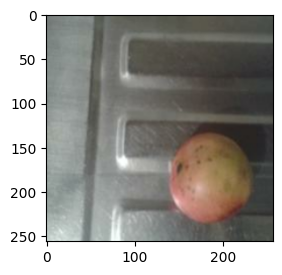

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_set.take(1):
    for i in range(9):
        az=plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")

In [ ]:
imported_model= tf.keras.applications.ResNet50(include_top=False,
input_shape=(256,256,3),
pooling='avg',
classes=2,
weights='imagenet')

imported_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
imported_model.output

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers import Adam

dnn_model = keras.Sequential()
dnn_model.add(tf.keras.layers.InputLayer(shape=(256, 256, 3)))
dnn_model.add(imported_model)
dnn_model.add(tf.keras.layers.Flatten())
dnn_model.add(tf.keras.layers.Dense(512, activation='relu'))
dnn_model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

dnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])

dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,637,826 (93.99 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
cnn = dnn_model.fit(
train_set,
validation_data=validation_set,
epochs=30
)

Epoch 1/30
 2/95 ━━━━━━━━━━━━━━━━━━━━ 1:14:30 48s/step - accuracy: 0.4922 - loss: 1.7581 - precision: 0.4922 - recall: 0.4922

KeyboardInterrupt: 

In [ ]:
dnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,738,056 (102.00 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2,100,230 (8.01 MB)

In [ ]:
loss, accuracy, recall, precision= dnn_model.evaluate(validation_set)

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 313ms/step - accuracy: 0.9987 - loss: 0.0035 - precision: 0.9987 - recall: 0.9987


In [ ]:
dnn_model.save('mangomodel.keras', overwrite=True)

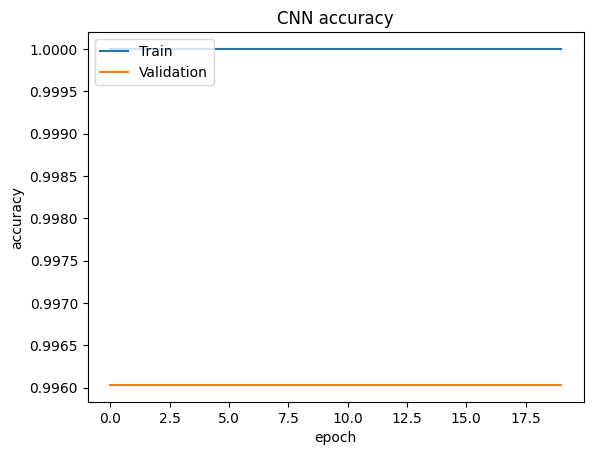

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

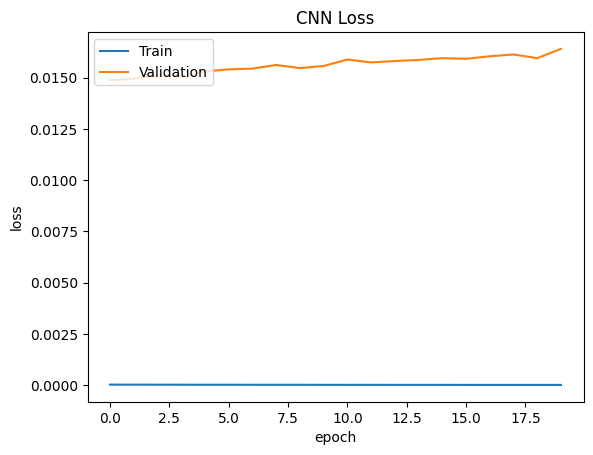

In [ ]:
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

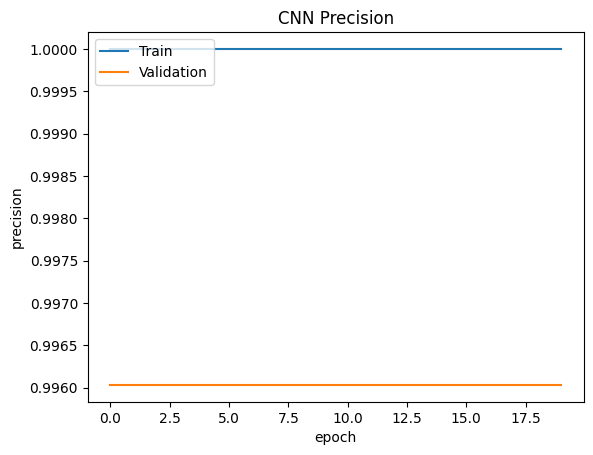

In [ ]:
plt.plot(cnn.history['precision'])
plt.plot(cnn.history['val_precision'])
plt.title('CNN Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


---
### Bellpepper by Pushpal Patil


#### Introduction

In recent years, the application of computer vision in agriculture has gained significant traction due to its potential to revolutionize farming practices. One critical area where computer vision can make a substantial impact is in the classification of fruits and vegetables based on their health status. This project aims to develop a robust computer vision model using Keras, KerasCV, and TensorFlow to classify images of fruits and vegetables as either healthy or rotten.

The classification of fruits and vegetables is crucial for various stakeholders in the agricultural supply chain, including farmers, retailers, and consumers. For farmers, early detection of rotten produce can help in reducing waste and optimizing harvesting practices. For retailers, accurate classification can enhance inventory management and ensure that only high-quality products reach the shelves. For consumers, it provides assurance of the quality and safety of the produce they purchase.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Problem Statement
The primary objective of this project is to develop an efficient and accurate image classification model that can differentiate between rotten and healthy fruits and vegetables. The ability to automatically detect and classify the condition of produce is crucial for several reasons:


In [ ]:
!nvidia-smi

Tue Nov 19 18:35:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import shutil
import keras
import random
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import image_dataset_from_directory
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

fruits_data.

-> train (fresh & rotten).

-> test (fresh & rotten).

80% train : 70% training ->  10% validation,  
20% test

#### Imports

In [ ]:
#gives the directories inside a capitol directory
def get_sub_dirs(directory):
    sub_dirs = []
    for root, _, _, in os.walk(directory):
        if root.split('/')[-1].split('__')[-1] in ['rotten', 'fresh']:
            sub_dirs.append(root)
    sub_dirs.sort()
    return sub_dirs
train_sub_dirs = get_sub_dirs('/content/drive/MyDrive/fruits_data/train')
test_sub_dirs = get_sub_dirs('/content/drive/MyDrive/fruits_data/test')

# diff types of images jpg, jpeg, png - converts into 1 type : jpg
def get_img_extensions_dict(dir_paths):
    img_extension_dict = {}
    for path in dir_paths:
        for filename in os.listdir(path):
            _, file_extension = os.path.splitext(filename)
            if file_extension not in img_extension_dict:
                img_extension_dict[file_extension] = 1
            else:
                img_extension_dict[file_extension] += 1
    return img_extension_dict

# different forms of color for diff images - converts images into 1 type of color channel representation
def count_color_channels(folder_paths):
    channel_counts = {}
    mode_to_channels = {'L': 1, 'LA': 2, 'P': 1, 'RGB': 3, 'RGBA': 4, 'CMYK': 4, 'YCbCr': 3, 'HSV': 3, 'LAB': 3, 'I': 1, 'F': 1}
    for folder_path in folder_paths:
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            try:
                with Image.open(file_path) as img:
                    mode = img.mode
                    channels = mode_to_channels.get(mode)
                    if channels is not None:
                        if channels in channel_counts:
                            channel_counts[channels] += 1
                        else:
                            channel_counts[channels] = 1
                    else:
                        print(f"Unrecognized mode {mode} for file {file_path}")
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    return channel_counts

color_channel_counts = count_color_channels(train_sub_dirs)
print(color_channel_counts)


{3: 842}


resNet50 - overfitted

In [ ]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up ImageDataGenerator with ResNet50 preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2  # Optionally use a subset of training data for validation
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# Define paths to train and test directories
train_dir = '/content/drive/MyDrive/fruits_data/train'  # Adjust to your specific path in Drive
test_dir =  '/content/drive/MyDrive/fruits_data/test'   # Adjust to your specific path in Drive

# Create train and test generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Use 'categorical' if you have more than two classes
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 675 images belonging to 2 classes.
Found 167 images belonging to 2 classes.
Found 354 images belonging to 2 classes.


842 training (validation + training) images - 16 processed per batch.

Runs 22 times to run all images - 16x22 = 1 epoch



sigmoid output is the probability of the image it is currently processing : 50% > is freshness / rottenness.      

the other 50 is the other class


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define ResNet50 base model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
)

# Modify the model with input resizing, dropout, and additional layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Dropout(0.5)(x)  # Add a dropout layer with 50% dropout rate
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # 'sigmoid' for binary classification
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    metrics=['accuracy']
)

# Print the model summary
model.summary()

# Define callbacks for early stopping and learning rate reduction
# if accuracy is not going up from what it has learned, then stop
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    callbacks=[]
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7482 - loss: 0.5535 - val_accuracy: 0.9222 - val_loss: 0.3014
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 506ms/step - accuracy: 0.9922 - loss: 0.0308 - val_accuracy: 0.9341 - val_loss: 0.2847
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 525ms/step - accuracy: 0.9935 - loss: 0.0168 - val_accuracy: 0.9521 - val_loss: 0.2147
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 518ms/step - accuracy: 0.9992 - loss: 0.0080 - val_accuracy: 0.9641 - val_loss: 0.1148
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - accuracy: 0.9974 - loss: 0.0149 - val_accuracy: 0.9581 - val_loss: 0.2387
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 523ms/step - accuracy: 0.9990 - loss: 0.0076 - val_accuracy: 0.9341 - val_loss: 0.3068
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 509ms/step - accuracy: 0.9922 - loss: 0.0248 - val_accuracy: 0.9281 - val_loss: 0.2515
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 518ms/step - accuracy: 0.9936 - loss: 0.0151 - val_accurac

#### Plotting the model accuracy and model loss

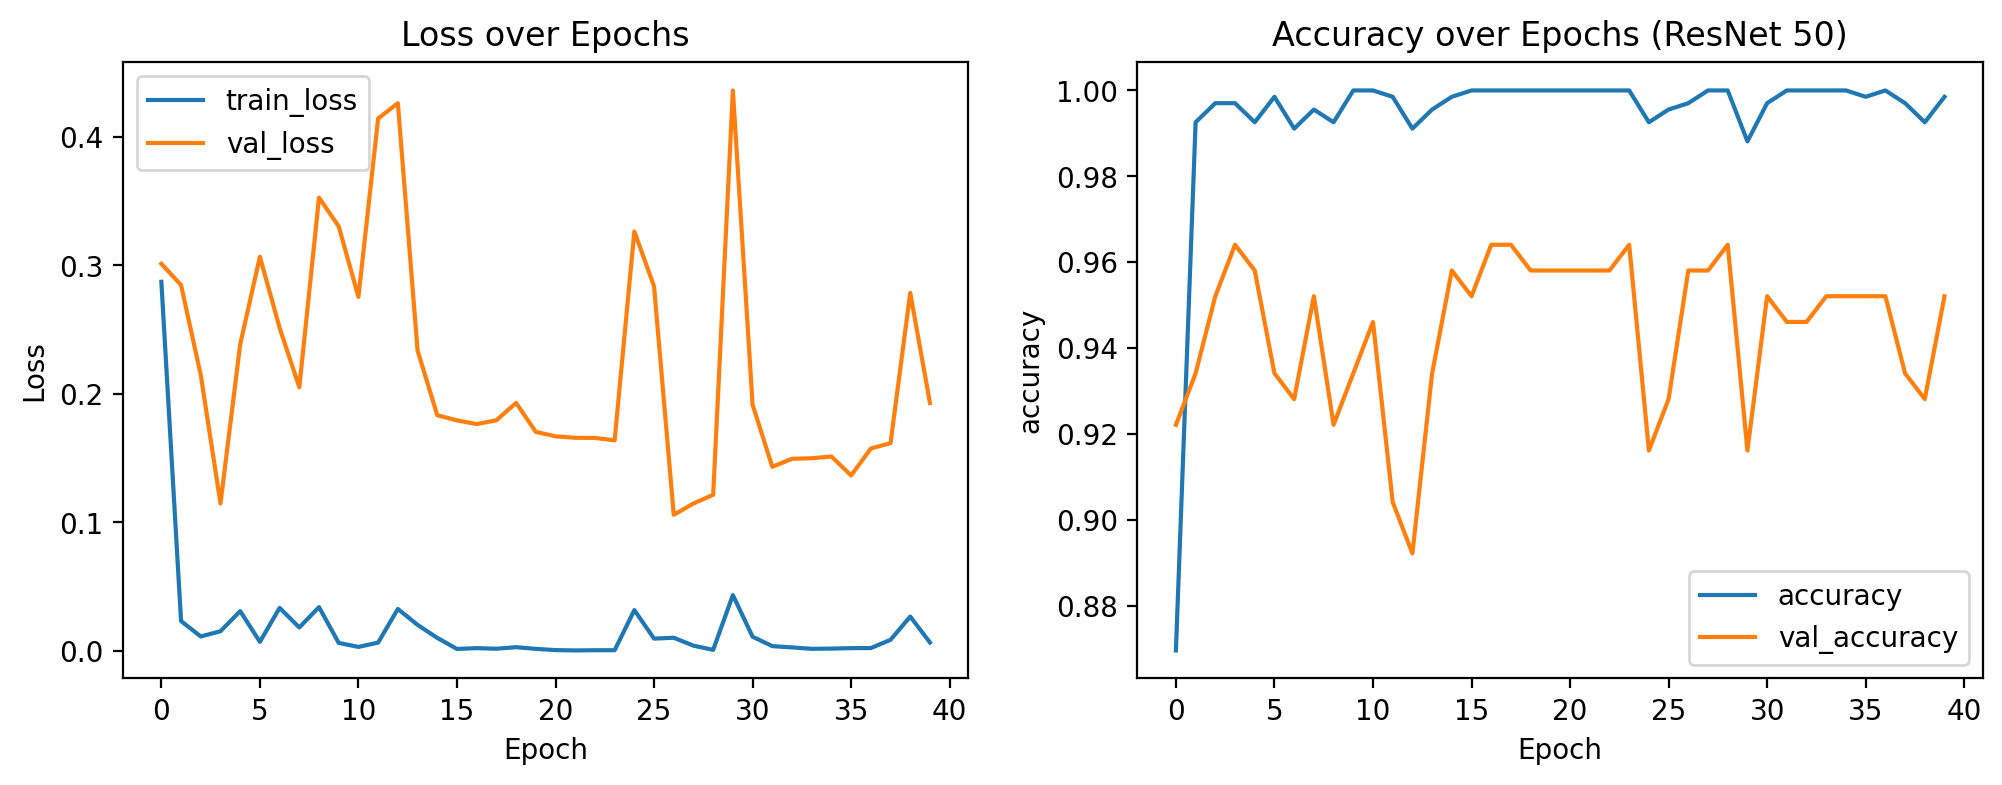

In [ ]:
plt.figure(figsize=(12, 4), dpi=200)
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy over Epochs (ResNet 50)')

plt.show();

graphs show overfitting


#### Model Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class labels

# Get true labels from the generator
y_true = test_generator.classes

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 277s 21s/step
Classification Report:

              precision    recall  f1-score   support

       fresh       0.49      0.52      0.51       176
      rotten       0.50      0.47      0.49       178

    accuracy                           0.50       354
   macro avg       0.50      0.50      0.50       354
weighted avg       0.50      0.50      0.50       354

Confusion Matrix:

[[92 84]
 [94 84]]


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights to handle any class imbalance
y_train = train_generator.classes  # Get labels from the training generator
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define EfficientNetB0 model
base_model = EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)

# Unfreeze the top layers of EfficientNetB0 for fine-tuning
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers (adjust as needed)
    layer.trainable = True

# Modify the model with dropout and additional layers with regularization
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = tf.keras.layers.Dropout(0.5)(x)  # Dropout layer after the base model
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Dense layer with L2 regularization
x = tf.keras.layers.Dropout(0.5)(x)  # Additional dropout layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Output layer for binary classification
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with class weights
history_1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.5531 - loss: 4.9646 - val_accuracy: 0.5988 - val_loss: 4.9008 - learning_rate: 1.0000e-05
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 348ms/step - accuracy: 0.5536 - loss: 4.9640 - val_accuracy: 0.7186 - val_loss: 4.8507 - learning_rate: 1.0000e-05
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - accuracy: 0.6375 - loss: 4.8762 - val_accuracy: 0.7844 - val_loss: 4.8024 - learning_rate: 1.0000e-05
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.6416 - loss: 4.8434 - val_accuracy: 0.8443 - val_loss: 4.7527 - learning_rate: 1.0000e-05
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.7038 - loss: 4.7748 - val_accuracy: 0.8683 - val_loss: 4.7043 - learning_rate: 1.0000e-05
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.7516 - loss: 4.7272 - val_accuracy: 0.8922 - val_loss: 4.6595 - learning_rate: 1.0000e-05
Epoch 7/30
22

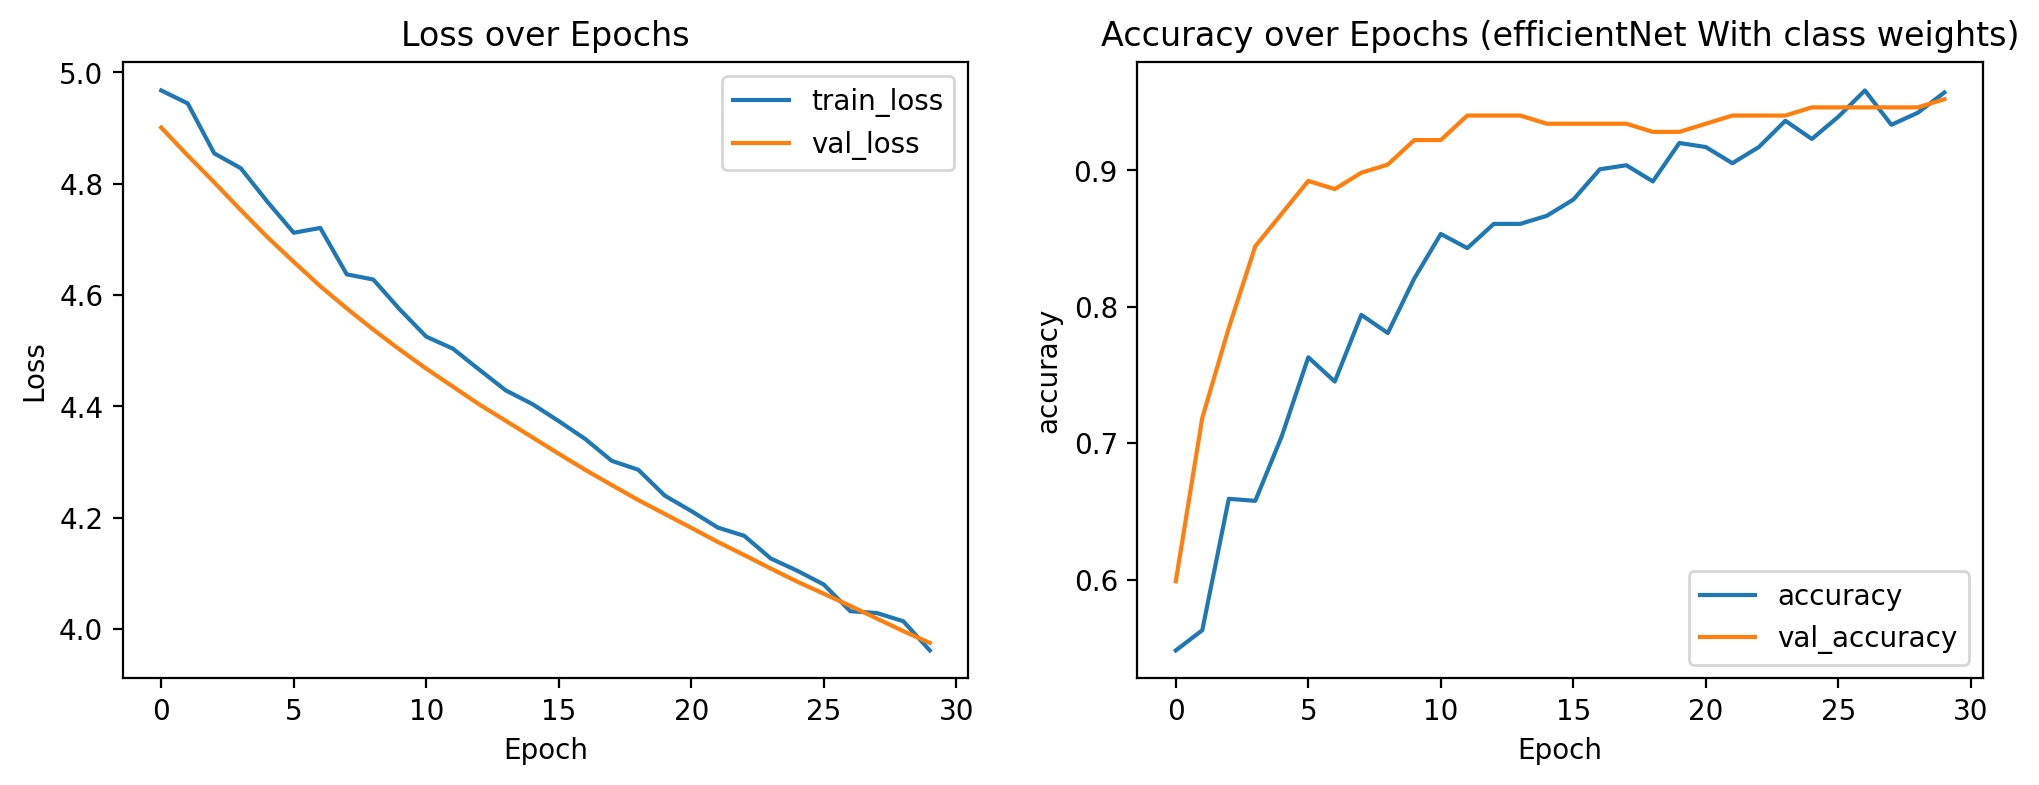

In [ ]:
plt.figure(figsize=(12, 4), dpi=200)
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='train_loss')
plt.plot(history_1.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], label='accuracy')
plt.plot(history_1.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy over Epochs (efficientNet With class weights)')

plt.show();

ResNet50 -  ~ 23.5 mil parameters - requires minimum 2,000 images

EfficentNet - Dynamically understands the global minimum and calculates accuracy accordingly . Residual connections and concept guidance. ~ 5.3 mil parameters.

Dataset too small for parameters to work properly - especially with ResNet50.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class labels

# Get true labels from the generator
y_true = test_generator.classes

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))


### References
[1] 	“U.S. fruit & Vegetables Market Size, Share | Industry Report, 2018-2025,” Grandviewresearch.com, 2018. https://www.grandviewresearch.com/industry-analysis/us-fruit-vegetables-market 

[2] 	Bridget Reed Morawski, “How supermarkets and grocery stores contribute to food waste,” one5c, Mar. 14, 2024. https://one5c.com/food-waste-supermarkets-136944209  (accessed Sep. 27, 2024).

[3]    “Fruits fresh and rotten for classification,” www.kaggle.com. https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification (accessed Sep. 27, 2024).

[4] 	Muhammad Subhan, 2024. “Fruit and Vegetable Disease (Healthy vs Rotten)” distributed by  Kaggle, https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten  (accessed Sep. 27, 2024).

[5] 	Alexander Kapturov, 2024. “Fruits by YOLO - Fruits Detection” distributed by Kaggle 